In [5]:
import jax3dp3 as j
import os
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
from PIL import Image
import io
import numpy as np
import matplotlib

intrinsics = j.Intrinsics(
    height=150,
    width=150,
    fx=200.0, fy=200.0,
    cx=75.0, cy=75.0,
    near=0.001, far=1.0
)


model_dir = os.path.join(j.utils.get_assets_dir(), "bop/ycbv/models")

renderer = j.Renderer(intrinsics)
model_names = j.ycb_loader.MODEL_NAMES
for IDX in range(len(model_names)):
    mesh_path_ply = os.path.join(model_dir,"obj_" + "{}".format(IDX+1).rjust(6, '0') + ".ply")
    mesh = j.mesh.load_mesh(mesh_path_ply)
    renderer.add_mesh(mesh, scaling_factor=1.0/1000.0)

[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (160, 160, 1024)


In [6]:
j.meshcat.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/


In [57]:
def make_outlier_posterior_graph(x,y):
    plt.clf()
    plt.figure(figsize=(7,4))
    color = np.array([229, 107, 111])/255.0
    plt.bar(
        np.arange(len(x)),
        y,
        color=color
    )
    plt.xticks(np.arange(len(x)), ["{:0.2f}".format(x) for x in jnp.round(OUTLIER_PROBS,1)],fontsize=15)
    plt.yticks([ 0.2, 0.4, 0.6, 0.8, 1.0],fontsize=15)
    plt.xlabel("Outlier Probability",fontsize=20)
    plt.ylabel("Probability",fontsize=20)
    plt.tight_layout()
    img_buf = io.BytesIO()
    plt.savefig(img_buf, format='png')
    im = Image.open(img_buf)
    return im

def make_r_posterior_graph(x,y):
    plt.clf()
    plt.figure(figsize=(7,4))
    color = np.array([229, 107, 111])/255.0
    plt.bar(
        np.arange(len(x)),
        y,
        color=color
    )
    plt.xticks(np.arange(len(x)), x,fontsize=15)
    plt.yticks([ 0.2, 0.4, 0.6, 0.8, 1.0],fontsize=15)
    plt.xlabel("R",fontsize=20)
    plt.ylabel("Probability",fontsize=20)
    plt.tight_layout()
    img_buf = io.BytesIO()
    plt.savefig(img_buf, format='png')
    im = Image.open(img_buf)
    return im

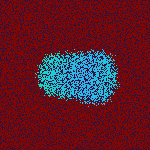

In [94]:
object_pose = j.distributions.gaussian_vmf_sample(
    jax.random.PRNGKey(2),
    j.t3d.transform_from_pos(
        jnp.array([0.0, 0.0, 0.3])
    ),
    0.001, 0.1
)
object_pose2 = j.distributions.gaussian_vmf_sample(
    jax.random.PRNGKey(2),
    j.t3d.transform_from_pos(
        jnp.array([0.05, 0.0, 0.2])
    ),
    0.001, 0.1
)

GT_ID = 3

original_observed_depth = renderer.render_multiobject(
    jnp.array([object_pose]),
    [GT_ID]
)[...,2]
original_observed_image = j.t3d.unproject_depth(original_observed_depth, intrinsics)

# original_observed_depth = renderer.render_multiobject(
#     jnp.array([object_pose, object_pose2]),
#     [GT_ID, 16]
# )[...,2]
# original_observed_image = j.t3d.unproject_depth(original_observed_depth, intrinsics)

GT_R = 0.00001
point_cloud = original_observed_image.reshape(-1,3)
noise = jax.vmap(
    lambda key: jax.random.multivariate_normal(
        key, jnp.zeros(3), jnp.eye(3) * GT_R
    )
)(
    jax.random.split(jax.random.PRNGKey(2), point_cloud.shape[0])
)
point_cloud_noisy = noise + point_cloud
# point_cloud_noisy = point_cloud
observed_image = point_cloud_noisy.reshape(original_observed_image.shape)
# observed_depth = j.render_point_cloud(point_cloud_noisy, intrinsics)[:,:,2]
# observed_depth = observed_depth.at[observed_depth < intrinsics.near].set(intrinsics.far)
# observed_image = j.t3d.unproject_depth_jit(observed_depth, intrinsics)
observed_image_viz = j.get_depth_image(j.render_point_cloud(point_cloud_noisy, intrinsics)[:,:,2])
observed_image_viz

In [95]:
j.meshcat.clear()
j.meshcat.show_cloud("1", observed_image.reshape(-1,3))

In [103]:
ID = GT_ID
# ID = 9
pose_estimate = object_pose

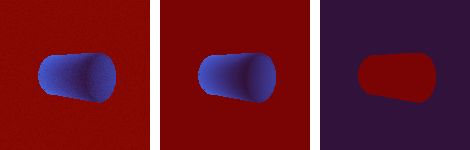

In [104]:
rendered = renderer.render_multiobject(
    jnp.array([pose_estimate]),
    [ID]
)
rendered_depth = rendered[...,2]
rendered_seg = rendered[...,3]
rendered_image = j.t3d.unproject_depth_jit(rendered_depth, intrinsics)
rendered_image_viz = j.get_depth_image(rendered_image[:,:,2],max=intrinsics.far)
j.hstack_images(
    [
        j.get_depth_image(observed_image[:,:,2]),
        rendered_image_viz,
        j.get_depth_image(rendered_seg)
    ]
)

In [105]:
R2 = jnp.array([0.000001, 0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01])
R1 = jnp.ones_like(R2) * 0.00001
R = jnp.vstack([R1.T, R2.T]).T
OUTLIER_PROBS = jnp.linspace(0.1, 0.5, 10)
OUTLIER_VOLUME = 1.0

In [106]:
likelihood_jit = jax.vmap(jax.vmap(j.threedp3_likelihood,
       in_axes=(None, None, None, None, 0, None)),
       in_axes=(None, None, None, 0, None, None)
)

In [107]:
p = likelihood_jit(observed_image, rendered_image, rendered_seg, R, OUTLIER_PROBS, OUTLIER_VOLUME)

actual R:  1e-05
R:  [1.e-05 1.e-05]  Outlier Prob:  0.1


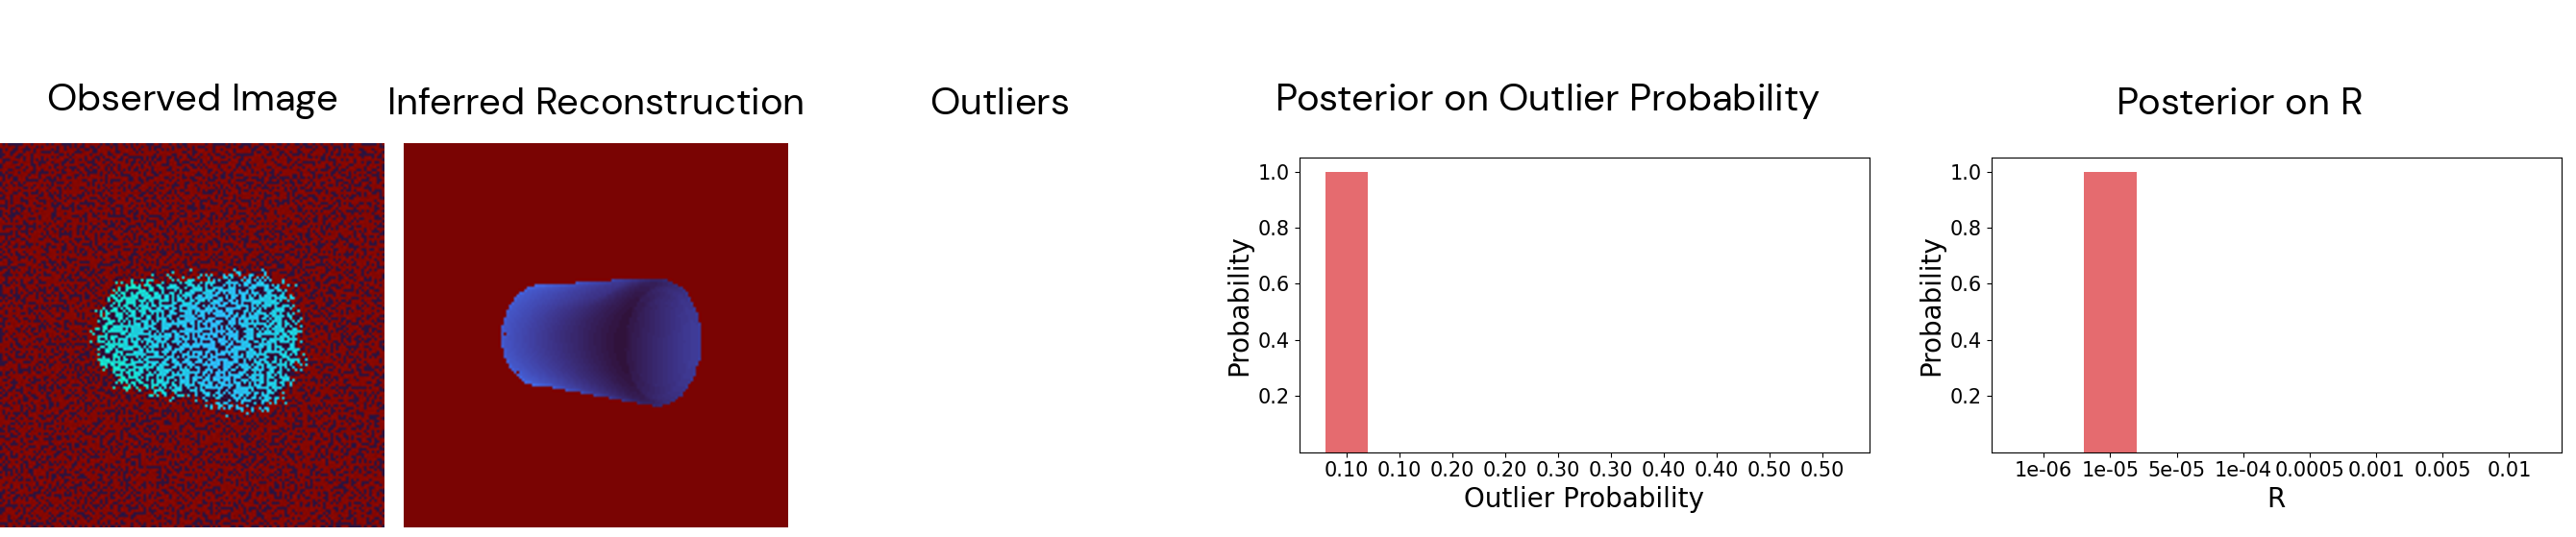

<Figure size 640x480 with 0 Axes>

<Figure size 700x400 with 0 Axes>

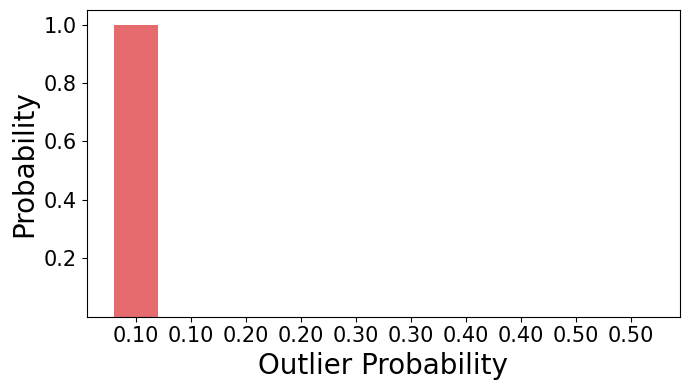

In [112]:
ii,jj = jnp.unravel_index(p.argmax(), p.shape)
best_r, best_outlier_prob = (R[ii], OUTLIER_PROBS[jj])
print("actual R: ", GT_R)
print("R: ", best_r, " Outlier Prob: ", best_outlier_prob)
r_viz = make_r_posterior_graph(R[:,1], j.utils.normalize_log_scores(p).sum(1))
outlier_prob_viz = make_outlier_posterior_graph(OUTLIER_PROBS, j.utils.normalize_log_scores(p).sum(0));

mixture_probs = j.gaussian_mixture_image(observed_image, rendered_image, rendered_seg,best_r)
outliers = (
    mixture_probs * (1.0 - best_outlier_prob) 
        <
    (best_outlier_prob / OUTLIER_VOLUME)
)
outlier_viz = j.get_depth_image(1.0 * outliers, cmap=matplotlib.colormaps['Greys'])

height_factor = outlier_prob_viz.height / observed_image_viz.height
panel = j.multi_panel(
    [
        j.scale_image(observed_image_viz,height_factor),
        j.scale_image(rendered_image_viz,height_factor),
        j.scale_image(outlier_viz,height_factor),
        outlier_prob_viz, r_viz],
    labels=["Observed Image", "Inferred Reconstruction", "Outliers", "Posterior on Outlier Probability", "Posterior on R"],
    label_fontsize=40,
    middle_width = 20
)
panel

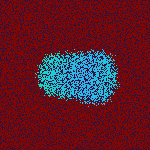

In [109]:
point_cloud = original_observed_image.reshape(-1,3)
noise = jax.vmap(
    lambda key: jax.random.multivariate_normal(
        key, jnp.zeros(3), jnp.eye(3) * best_r[1]
    )
)(
    jax.random.split(jax.random.PRNGKey(2), point_cloud.shape[0])
)
point_cloud_noisy = noise + point_cloud
# point_cloud_noisy = point_cloud
# observed_depth = j.render_point_cloud(point_cloud_noisy, intrinsics)[:,:,2]
# observed_depth = observed_depth.at[observed_depth < intrinsics.near].set(intrinsics.far)
# observed_image = j.t3d.unproject_depth_jit(observed_depth, intrinsics)
j.get_depth_image(j.render_point_cloud(point_cloud_noisy, intrinsics)[:,:,2])